## Import Libraries

In [71]:
import pandas as pd
import numpy as np
import random
import string
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict 

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
from sklearn.base import BaseEstimator
from nltk.stem.wordnet import WordNetLemmatizer

import collections
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.layers import Bidirectional
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.callbacks import TensorBoard



tqdm.pandas()
%matplotlib inline

In [72]:
train = pd.read_csv('../../data/nlp_tweet_data/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [73]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [74]:
train.shape

(7613, 5)

In [75]:
test = pd.read_csv('../../data/nlp_tweet_data/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [76]:
test.shape

(3263, 4)

In [77]:
class_indexes = list(train['target'].value_counts().index)

## Pre-processing

In [78]:
 def clean_text(text, remove_stopwords=True, stem_words=False, lemma=True):
    # Clean the text, with the option to remove stopwords and to stem words.

        text = str(text).lower().split()

        # Optionally, remove stop words
#         if remove_stopwords:
#             stops = set(stopwords.words("english"))
#             text = [w for w in text if not w in stops]

        text = " ".join(text)
        
        # remove URLs
        url = re.compile(r'https?://\S+|www\.\S+')
        text = url.sub(r'',text)
        
        # remove html tags
        text = re.sub(r'<.*?>', "", text)
        
        # remove emoji
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        
        
        text = emoji_pattern.sub(r'', text)
        
        # remove punctuation from text
        text  = "".join([char for char in text if char not in string.punctuation])

        # Clean the text
        text = re.sub(r"[-()\"#/<>!@&;*:<>{}`'+=~%|.!?,_]", " ", text)
        text = re.sub(r"\]", " ", text)
        text = re.sub(r"\[", " ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\\", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"  ", " ", text)
        text = re.sub(r"   ", " ", text)
        text = re.sub(r"   ", " ", text)
        text = re.sub(r"0x00", "", text)
        
        

        # Optionally, shorten words to their stems
        if stem_words:
            text = text.split()
            stemmer = SnowballStemmer('english')
            stemmed_words = [stemmer.stem(word) for word in text]
            text = " ".join(stemmed_words)

        if lemma:
            text = text.split()
            lem = WordNetLemmatizer()
            lemmatized = [lem.lemmatize(word,"v") for word in text]
            text = " ".join(lemmatized)

        # Return a list of words
        return(text)

In [79]:
def performance_plots(y_test_sample, y_pred, ml_algo):
    print("---------"+ml_algo+"-----------")
    acc = metrics.accuracy_score(y_pred, y_test_sample)
    print("Accuracy: ",acc)
    print("NORMALISED CM  for Tag6")
    cm = confusion_matrix(y_test_sample,y_pred)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    ind = class_indexes
    cols = class_indexes
    cm_df = pd.DataFrame(norm_cm,cols,ind)
    plt.figure(figsize=(22,10)) 
    sns.heatmap(cm_df, annot=True,cmap = "Greens",fmt='g')
    print(classification_report(y_test_sample,y_pred))
    print(accuracy_score(y_test_sample, y_pred))
    return

In [80]:
train['text'] = train['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 7613/7613 [00:00<00:00, 11404.88it/s]


In [81]:
test['text'] = test['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 3263/3263 [00:00<00:00, 11534.15it/s]


## Convert data for topic modeling

In [64]:
all_data = train.append(test)

In [82]:
stop_words = stopwords.words('english')

In [66]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod
    
def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    df['text'] = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram


In [67]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(all_data)

In [68]:
lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                       corpus=train_corpus4,
                       num_topics=10,
                       id2word=train_id2word4,
                       chunksize=100,
                       workers=2, # Num. Processing Cores - 1
                       passes=50,
                       eval_every = 1,
                       per_word_topics=True)

In [69]:
lda_train4.print_topics(10,num_words=15)[:10]

[(0,
  '0.028*"uo" + 0.027*"two" + 0.023*"emergency" + 0.021*"warn" + 0.018*"happen" + 0.016*"build" + 0.016*"life" + 0.015*"years" + 0.015*"injure" + 0.014*"sinkhole" + 0.014*"face" + 0.013*"severe_thunderstorm" + 0.012*"whole" + 0.012*"kill" + 0.011*"people"'),
 (1,
  '0.035*"attack" + 0.031*"flood" + 0.026*"world" + 0.026*"wound" + 0.026*"live" + 0.023*"go" + 0.022*"right" + 0.019*"fuck" + 0.017*"thunder" + 0.016*"train" + 0.014*"cant" + 0.013*"also" + 0.013*"may" + 0.012*"women" + 0.012*"failure"'),
 (2,
  '0.023*"survive" + 0.021*"make" + 0.020*"take" + 0.019*"think" + 0.018*"get" + 0.018*"come" + 0.017*"rescue" + 0.016*"would" + 0.015*"panic" + 0.015*"time" + 0.013*"show" + 0.012*"back" + 0.012*"people" + 0.011*"one" + 0.011*"still"'),
 (3,
  '0.031*"new" + 0.028*"love" + 0.020*"drown" + 0.018*"even" + 0.016*"nuclear" + 0.015*"collapse" + 0.014*"stop" + 0.013*"obliterate" + 0.013*"many" + 0.013*"death" + 0.012*"part" + 0.012*"crush" + 0.011*"go" + 0.011*"give" + 0.011*"one"'),
 (

In [70]:
train_corpus4[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

In [30]:
train_vecs=[]
for i in range(len(all_data)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    train_vecs.append(topic_vec)

In [33]:
train_vecs[0]

[0.01666727,
 0.01666727,
 0.01666727,
 0.01666727,
 0.01666727,
 0.01666727,
 0.016674217,
 0.8499876,
 0.01666727,
 0.01666727]

In [34]:
topic_model_df = pd.DataFrame.from_records(train_vecs)
topic_model_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016674,0.849988,0.016667,0.016667
1,0.619992,0.020001,0.020001,0.020001,0.020001,0.020001,0.020001,0.020001,0.020001,0.220000
2,0.011112,0.011112,0.233296,0.122211,0.011112,0.011112,0.011112,0.566696,0.011112,0.011123
3,0.299987,0.014288,0.184686,0.014287,0.014288,0.014287,0.014287,0.014287,0.014287,0.415317
4,0.137429,0.012502,0.012502,0.155766,0.012504,0.619291,0.012502,0.012502,0.012502,0.012502


In [42]:
topic_model_df.shape

(10876, 10)

## TFIDF Vectorizer

In [36]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000)
tfidf_vect.fit(all_data['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [37]:
all_data_tfidf =  tfidf_vect.transform(all_data['text'])

In [38]:
all_data_tfidf_df = pd.DataFrame(all_data_tfidf.toarray())

In [40]:
all_data_tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
10871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.373517,0.0
10872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
10873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
10874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
10875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [41]:
all_data_tfidf_df.shape

(10876, 1000)

In [43]:
combine_df = pd.concat([topic_model_df, all_data_tfidf_df], axis=1)
combine_df.shape

(10876, 1010)

In [44]:
combine_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016674,0.849988,0.016667,0.016667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.619992,0.020001,0.020001,0.020001,0.020001,0.020001,0.020001,0.020001,0.020001,0.220000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.011112,0.011112,0.233296,0.122211,0.011112,0.011112,0.011112,0.566696,0.011112,0.011123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.299987,0.014288,0.184686,0.014287,0.014288,0.014287,0.014287,0.014287,0.014287,0.415317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.137429,0.012502,0.012502,0.155766,0.012504,0.619291,0.012502,0.012502,0.012502,0.012502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
train_new = combine_df[:train.shape[0]]
test_new = combine_df[train.shape[0]:]

In [46]:
x_train, x_test, y_train, y_test = train_test_split(train_new, train['target'])
print('train shape: ',x_train.shape)
print('test shape: ',x_test.shape)

train shape:  (5709, 1010)
test shape:  (1904, 1010)


## ML models

In [47]:
class MyClassifier(BaseEstimator):

    def __init__(self, classifier_type):
        """
        A Custome BaseEstimator that can switch between classifiers.
        :param classifier_type: string - The switch for different classifiers
        """
        self.classifier_type = classifier_type


    def fit(self, X, y=None):
        if self.classifier_type == 'LDA':
            self.classifier_ = LinearDiscriminantAnalysis(solver='svd')
        elif self.classifier_type == 'Logistic Regression':
            self.classifier_ = LogisticRegression(C=1.0, dual= False, max_iter=500,penalty = 'l2' , 
                                                  solver = 'liblinear', class_weight='balanced', 
                                                  multi_class='ovr', random_state=42, tol=1e-05)
        elif self.classifier_type == 'LinSVC':
            self.classifier_ = svm.LinearSVC(C=1.0, dual= False, fit_intercept=True,
     intercept_scaling =0.1, max_iter=1000,penalty = 'l2' , loss = 'squared_hinge', class_weight='balanced',
     multi_class='ovr', random_state=42, tol=1e-05, verbose=0)
        elif self.classifier_type == 'Random Forest':
            self.classifier_ = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
        elif self.classifier_type == 'Decision Tree':
            self.classifier_ = DecisionTreeClassifier()
        elif self.classifier_type == 'Gradient boost':
            self.classifier_ = GradientBoostingClassifier(n_estimators=50)
        else:
            raise ValueError('Unkown classifier type.')
        self.classifier_.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.classifier_.predict(X)
    

### LDA

In [48]:
lda_model = MyClassifier('LDA')
lda_model.fit(x_train, y_train)
lda_pred = lda_model.predict(x_test)

---------LDA-----------
Accuracy:  0.782563025210084
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1118
           1       0.76      0.69      0.72       786

    accuracy                           0.78      1904
   macro avg       0.78      0.77      0.77      1904
weighted avg       0.78      0.78      0.78      1904

0.782563025210084


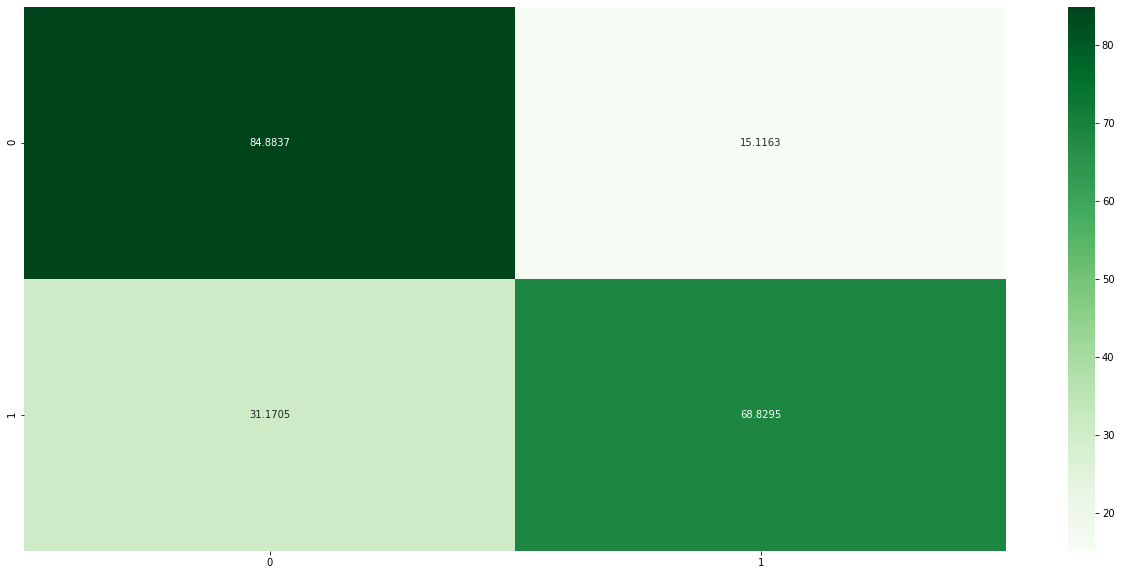

In [49]:
performance_plots(y_test, lda_pred, 'LDA')

### logistic Regression

In [50]:
logistic_model = MyClassifier('Logistic Regression')
logistic_model.fit(x_train, y_train)
logistic_pred = logistic_model.predict(x_test)

---------Logistic Regression-----------
Accuracy:  0.7815126050420168
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1118
           1       0.73      0.74      0.74       786

    accuracy                           0.78      1904
   macro avg       0.77      0.78      0.78      1904
weighted avg       0.78      0.78      0.78      1904

0.7815126050420168


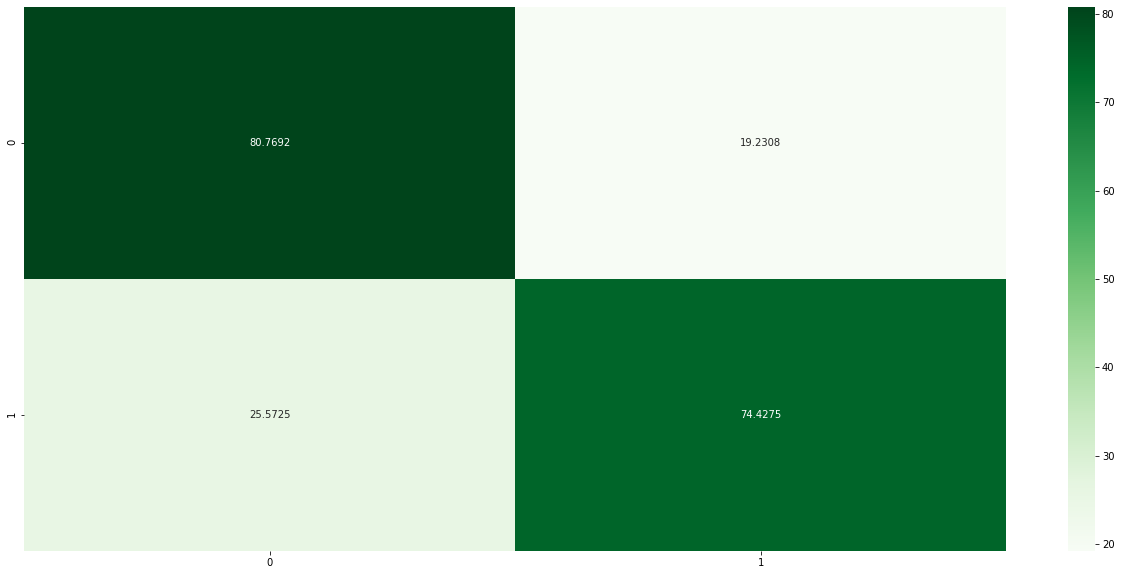

In [51]:
performance_plots(y_test, logistic_pred, 'Logistic Regression')